In [30]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import asyncio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [63]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
x_metric = "eval_param"
tags = ["custom_sweep"]
filters = {"config.compute_budget": 64, "config.puct_c": 2}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [64]:
# crete a dataframe from runs and summary metrics

data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

df


100%|██████████| 70/70 [00:00<00:00, 399.07it/s]


,_timestamp,Self_Play/Mean_Reward,Training/Replay_Buffer_Size,Self_Play/Timesteps,Self_Play/Reward_STD,Self_Play/Cumulative_Reward,max_Self_Play/Mean_Reward_step,Self_Play/Entropies,Self_Play/Min_Timesteps,max_Self_Play/Mean_Reward,...,max_episode_length,policy_loss_weight,sample_batch_ratio,regularization_weight,tree_evaluation_policy,replay_buffer_multiplier,max_Max_Reward,max_max_reward_step,max_reward_step,max_Mean_Reward
0,1.707102e+09,-13.500,80,"{'_type': 'histogram', 'values': [6, 0, 0, 0, ...",0.925820,-922.875,8,"{'bins': [0.09179931420546313, 0.0926139476589...",13,-13.000,...,200,30,1,0.0001,minimal_variance_constraint,10,NaN,NaN,NaN,NaN
1,1.707102e+09,-18.000,80,"{'values': [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",2.618615,-960.875,11,"{'bins': [0.199351437886556, 0.201834391770155...",15,-15.250,...,200,30,1,0.0001,minimal_variance_constraint,10,NaN,NaN,NaN,NaN
2,1.707101e+09,-13.375,80,"{'_type': 'histogram', 'values': [6, 0, 0, 0, ...",0.744024,-1170.625,7,"{'bins': [0.12991438462184027, 0.1300316780327...",13,-13.000,...,200,30,1,0.0001,minimal_variance_constraint,10,NaN,NaN,NaN,NaN
3,1.707100e+09,-33.000,80,"{'bins': [20, 20.40625, 20.8125, 21.21875, 21....",10.099505,-1330.125,9,"{'bins': [0.4280328750610352, 0.43188187722549...",20,-22.875,...,200,30,1,0.0001,minimal_variance_constraint,10,NaN,NaN,NaN,NaN
4,1.707099e+09,-16.000,80,"{'bins': [15, 15.046875, 15.09375, 15.140625, ...",1.195229,-2298.250,12,"{'bins': [0.13361036076265223, 0.1340114579116...",15,-14.750,...,200,30,1,0.0001,minimal_variance_constraint,10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,1.706909e+09,-21.500,80,"{'bins': [17, 17.1875, 17.375, 17.5625, 17.75,...",4.070802,-1679.500,11,"{'bins': [0.27070948952122736, 0.2733382399848...",17,-21.250,...,200,30,1,0.0001,minimal_variance_constraint,10,-17.0,11.0,11.0,-21.250
66,1.706906e+09,-29.875,80,"{'bins': [15, 15.09375, 15.1875, 15.28125, 15....",36.459126,-2603.125,13,"{'bins': [0.20926969929745323, 0.2097638050330...",15,-17.875,...,200,30,1,0.0001,default,10,-15.0,13.0,13.0,-17.875
67,1.706893e+09,-13.250,80,"{'bins': [13, 13.03125, 13.0625, 13.09375, 13....",0.707107,-1815.375,9,"{'bins': [0.05193688777776865, 0.0522588807755...",13,-13.000,...,200,30,1,0.0001,minimal_variance_constraint,10,-13.0,9.0,9.0,-13.000
68,1.706892e+09,-17.625,80,"{'bins': [17, 17.03125, 17.0625, 17.09375, 17....",0.916125,-1582.250,14,"{'bins': [0.1334406628328211, 0.13488315308795...",17,-17.625,...,200,30,1,0.0001,minimal_variance_constraint,10,-17.0,14.0,14.0,-17.625


In [65]:
df.columns

Index(['_timestamp', 'Self_Play/Mean_Reward', 'Training/Replay_Buffer_Size',
       'Self_Play/Timesteps', 'Self_Play/Reward_STD',
       'Self_Play/Cumulative_Reward', 'max_Self_Play/Mean_Reward_step',
       'Self_Play/Entropies', 'Self_Play/Min_Timesteps',
       'max_Self_Play/Mean_Reward', 'Training/Value_and_Policy_loss',
       '_runtime', 'Self_Play/Mean_Timesteps', 'Self_Play/Total_Timesteps',
       'Training/Value_Simularities', 'Training/Value_loss',
       'Self_Play/Min_Reward', 'Training/Policy_loss', '_wandb',
       'Self_Play/EMA_Reward', 'Training/Learning_Rate',
       'Self_Play/Total_Runtime', 'Self_Play/Runtime_per_Timestep',
       'Self_Play/Total_Average_Reward', '_step', 'Self_Play/Rewards',
       'Self_Play/Mean_Entropy', 'Self_Play/Timesteps_STD',
       'Self_Play/Max_Reward', 'Training/Regularization_loss', 'env_id',
       'layers', 'puct_c', 'lr_gamma', 'eval_param', 'hidden_dim',
       'iterations', 'model_type', 'norm_layer', 'activation_fn',
      

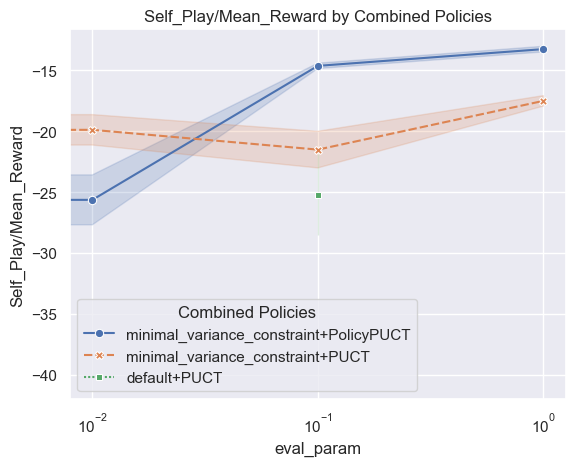

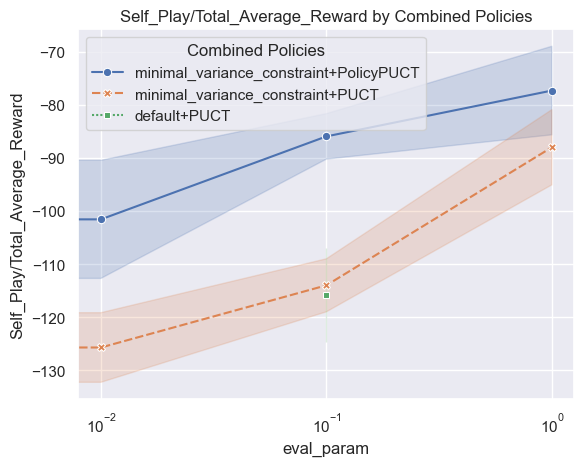

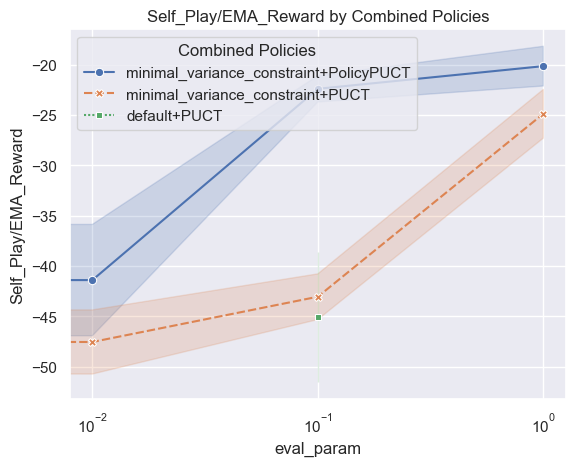

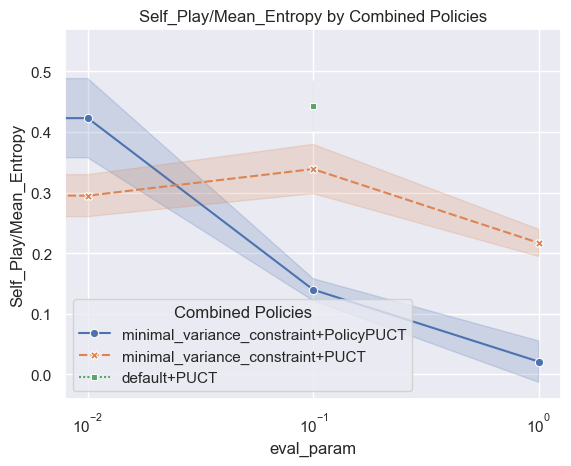

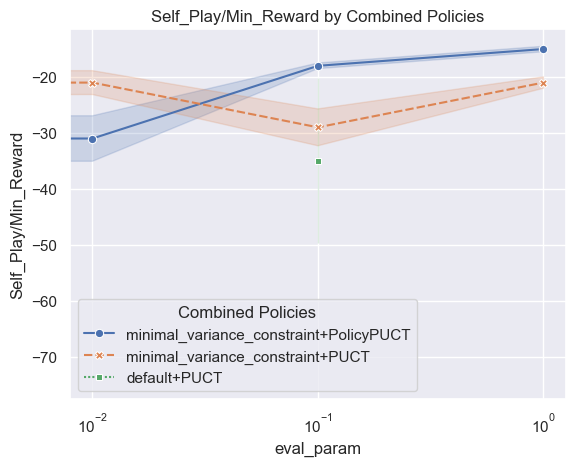

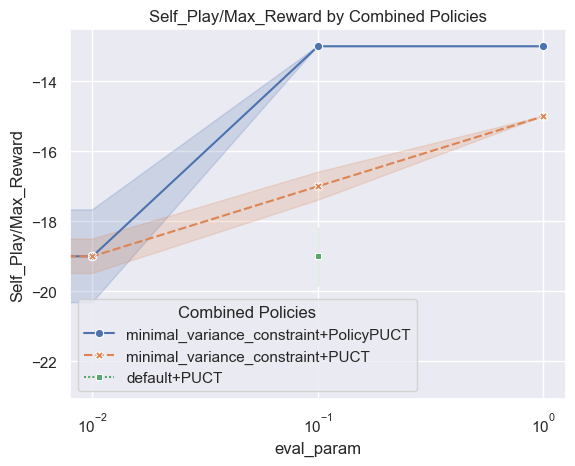

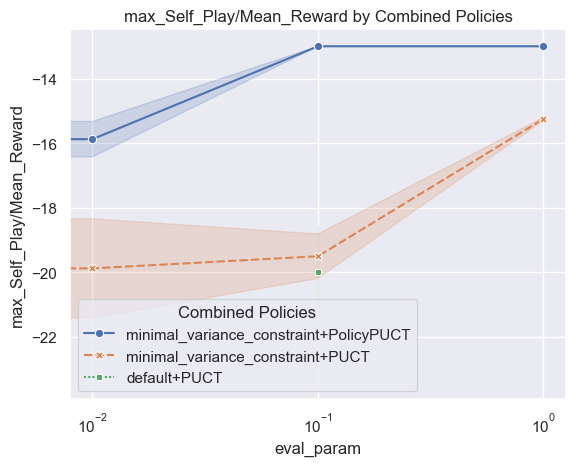

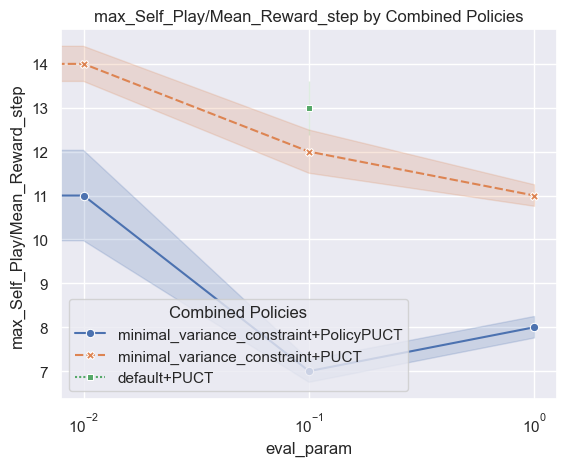

In [67]:


df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

metrics = ['Self_Play/Mean_Reward', "Self_Play/Total_Average_Reward", "Self_Play/EMA_Reward", 'Self_Play/Mean_Entropy', 'Self_Play/Min_Reward',
           'Self_Play/Max_Reward',
           'max_Self_Play/Mean_Reward', 'max_Self_Play/Mean_Reward_step'
           ]

for metric in metrics:
    sns.set_theme(style="darkgrid")

    # Create a line plot with confidence intervals
    sns.lineplot(data=df, x=x_metric, y=metric,
                hue="policy_combination", style="policy_combination",
                markers=True, errorbar="se", estimator=np.median)

    # Customize the plot with titles and labels
    plt.title(f'{metric} by Combined Policies')
    plt.xlabel(x_metric)  # Replace with actual x-axis label
    plt.ylabel(metric)
    plt.legend(title='Combined Policies')
    plt.gca().set_xscale('log', base=10)

    # Show the plot
    plt.show()
